In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../')
print(f"New working dir {os.getcwd()}")

Old working dir /home/alex/repos/conditional_quantile_function/poc
New working dir /home/alex/repos/conditional_quantile_function


In [17]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
from pushforward_operators import NeuralQuantileRegression, AmortizedNeuralQuantileRegression
from conformal.real_datasets.reproducible_split import get_dataset_split
from conformal.classes.method_desc import ConformalMethodDescription
from conformal.wrappers.cvq_regressor import CVQRegressor

In [18]:
from pushforward_operators.protocol import PushForwardOperator
from utils.quantile import get_quantile_level_analytically


def plot_quantile_levels_from_model(
    ax: matplotlib.axes.Axes,
    model: PushForwardOperator,
    conditional_value: torch.Tensor,
    number_of_quantile_levels: int,
    tensor_parameters: dict = {},
):

    quantile_levels = torch.linspace(0.05, 0.95, number_of_quantile_levels)
    radii = get_quantile_level_analytically(
        quantile_levels, distribution="gaussian", dimension=2
    )

    X_batch = conditional_value.repeat(1000, 1).to(**tensor_parameters)
    list_of_approximated_Y_quantiles = []

    with torch.no_grad():
        for _, contour_radius in enumerate(radii):
            pi = torch.linspace(-torch.pi, torch.pi, 1000)

            ground_truth_U_quantiles = (
                torch.stack(
                    [
                        contour_radius * torch.cos(pi),
                        contour_radius * torch.sin(pi),
                    ]
                ).T
            ).to(**tensor_parameters)


            try:
                approximated_Y_quantiels = model.push_u_given_x(
                    u=ground_truth_U_quantiles, x=X_batch
                )
            except NotImplementedError:
                approximated_Y_quantiels = None

            list_of_approximated_Y_quantiles.append(approximated_Y_quantiels)

    color_map = matplotlib.colormaps['viridis']

    for i, approximated_Y_quantiels in enumerate(list_of_approximated_Y_quantiles):
        color = color_map(i / number_of_quantile_levels)
        label = f'Quantile level {quantile_levels[i]:.2f}'

        if approximated_Y_quantiels is not None:
            ax.plot(
                approximated_Y_quantiels[:, 0],
                approximated_Y_quantiels[:, 1],
                color=color,
                linewidth=2.5,
                label=label
            )

    ax.legend(bbox_to_anchor=(1.1, 1.05))


In [5]:
from conformal.experiment import _tuned_configs
_params = _tuned_configs["bio"]
_params

{'hidden_dimension': 16,
 'number_of_hidden_layers': 4,
 'batch_size': 512,
 'n_epochs': 100,
 'warmup_iterations': 10,
 'learning_rate': 0.01,
 'dtype': torch.float32}

In [6]:
ds = get_dataset_split(name="bio", seed=0)
reg = CVQRegressor(feature_dimension=ds.n_features, response_dimension=ds.n_outputs, **_params)

In [7]:
reg.model = AmortizedNeuralQuantileRegression.load_class("./conformal_results/bio/0/model_cvqr.pth")

In [8]:
y_pred_test = reg.predict_mean(ds.X_test)

In [9]:
n_grid = 1000
Y0_grig, Y1_grid = np.meshgrid(np.linspace(-4, 4, n_grid), np.linspace(-4, 4, n_grid))
print(f"{Y0_grig.shape=}, {Y1_grid.shape=}")

#Y0_grig = Y0_grig.reshape(-1, 1)
#Y1_grid = Y1_grid.reshape(-1, 1)

Y_grid = np.concatenate((Y0_grig.reshape(-1, 1), Y1_grid.reshape(-1, 1)), axis=1)
Y_grid.shape


Y0_grig.shape=(1000, 1000), Y1_grid.shape=(1000, 1000)


(1000000, 2)

In [25]:
idx_test = 911
X0 = ds.X_test[[idx_test]]
X0_grid = np.repeat(X0, Y_grid.shape[0], axis=0)
X0_grid.shape

(1000000, 8)

In [ ]:
scores = reg.calculate_scores(X0_grid, Y_grid)

In [ ]:
u_sample = np.random.normal(size=(Y_grid.shape[0], 2), loc=0, scale=1)

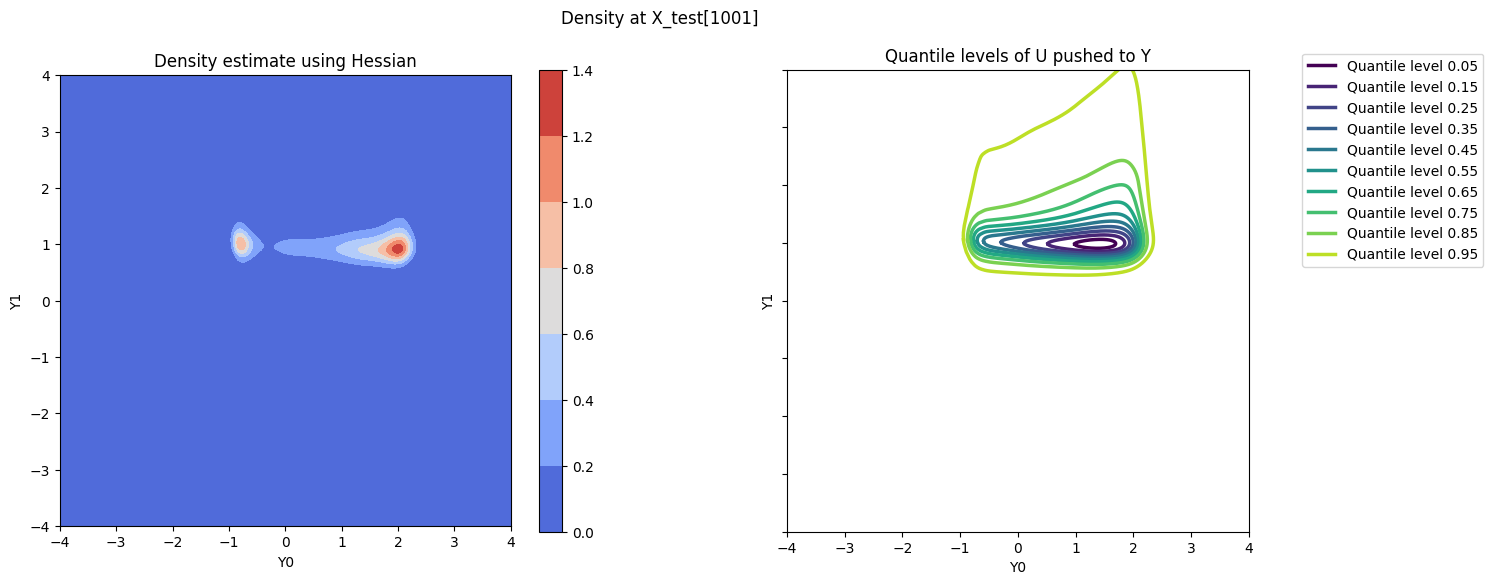

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
plt.suptitle(f"Density at X_test[{idx_test}]")
c0 = ax[0].contourf(Y0_grig, Y1_grid, np.exp(scores["Log Density"]).reshape(n_grid, n_grid), cmap="coolwarm")
plt.colorbar(c0)
ax[0].set_title('Density estimate using Hessian')
ax[0].set_xlabel('Y0')
ax[0].set_ylabel('Y1')

ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-4, 4)
ax[0].set_aspect("equal", adjustable='box')

plot_quantile_levels_from_model(
    ax[1],
    reg.model,
    torch.tensor(ds.X_test[idx_test], dtype=torch.float32),
    number_of_quantile_levels=10
)
ax[1].set_title('Quantile levels of U pushed to Y')
ax[1].set_xlabel('Y0')
ax[1].set_ylabel('Y1')

ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[1].set_aspect("equal", adjustable='box')
plt.show()

In [15]:
from matplotlib.collections import LineCollection


def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
